# **Grupo 14**

Trabalho realizado por:
* Beatriz Fernandes Oliveira A91640
* Catarina Martins Sá Quintas A91650

In [ ]:
!pip install ortools
 

In [ ]:
!pip install z3-solver

     |████████████████████████████████| 32.9 MB 82 kB/s 


# **Problema 2: Circuito Booleano**
Consideremeos um circuito booleano $\,\mathcal{C}\,$ constituído por $\,n\,$ “wires” de “input” e por um único “wire” de output. Para o descrever, utilizaremos um bi-grafo com uma classe de nodos, que representando  os “gates”,e a segunda classe, que representa os “wires”. 

$Requisitos$
* Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val contém uma variável SCIP; para as “gates” o campo val  contém uma marca bo conjunto and, or,  xor e not, que indica o tipo de “gate”. 
* Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
* No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
  

In [ ]:
import random
import numpy as np
import networkx as nx
from z3 import *


In [ ]:
def determine_each_node_value(n_input, gama):
  s = Solver()

  n_and, n_or, n_not, n_nodes  = Ints('n_and n_or n_not n_nodes')

  s.add(n_input + 2*n_and + 2*n_or + 2*n_not == n_nodes)
  s.add(ToInt(gama*ToReal(n_nodes)) == n_and)
  s.add(n_nodes >= n_input + 2)
  s.add(n_and > 0)
  s.add(n_or > 0)
  s.add(n_not > 0)

  if s.check()==sat :
      m = s.model()
      print(m)
      for d in m.decls():
          print("%s = %d" % (d.name(), m[d].as_long()))
  else: 
      print("Não tem solução.")
  
  return (m[n_nodes].as_long(),m[n_not].as_long(),m[n_or].as_long(),m[n_and].as_long())

In [ ]:
def generate_graph(n_input,n_not,n_or,n_and):
  #Função que recursivamente preenche o grafo
  def generate_graph_recursive(op_orig,node_index,ops,inputs,inputs_check,circuit,last):
    
    #Conetar a operação que estamos a fazer para o respetivo output
    circuit.add_edge(op_orig,"X"+str(node_index))

    #No caso de ser a operação NOT, só pode haver apenas uma entrada
    if op_orig.startswith("NOT"):
      #Verificar se existem ainda operações que não estão a ser utilizadas, e estamos na última oportunidade para as utilizar.  
      #Forçar que o node que connecta para o atual nodo é o resultado de uma operação.
      if last and len(ops)>0:
        n_index = random.randint(0,len(ops)-1)
        op = ops.pop(n_index)
        if len(ops)==0:
          last = False
        node_index = node_index + 1
        circuit.add_node("X"+str(node_index))
        circuit.add_edge("X"+str(node_index),op_orig)
        inputs_check, node_index = generate_graph_recursive(op,node_index,ops,inputs,inputs_check,circuit,last)
      
      #No caso de não importar o número de operações que ainda não foram utilizadas.  
      #Então o nodo connectado pode tanto ser um input ou o resultado de uma operação.
      else:  
        #Preenche com as possíveis operações.
        n_ops = 0
        if len(ops)>0:
          #Decide entre usar o node operação ou não.
          n_ops = random.randint(0,1)
          args = np.random.choice(ops, size=n_ops, replace=False)
          for arg in args:
            ops.remove(arg)
            node_index = node_index + 1
            circuit.add_node("X"+str(node_index))
            circuit.add_edge("X"+str(node_index),op_orig)
            inputs_check, node_index = generate_graph_recursive(arg,node_index,ops,inputs,inputs_check,circuit,last)
        
        #Preenche com o input, se anteriormente decidiu não usar o node de operação
        if n_ops == 0:
          n_index = random.randint(0,len(inputs)-1)
          arg = inputs[n_index]
          circuit.add_edge(arg,op_orig)
          if arg in inputs_check:
              inputs_check.remove(arg)

    #Podemos ter mais de que uma entrada
    else:
      #Preenche com as operações possíveis 
      n_ops=0
      if len(ops)>0:
        min_args = 0 
        if last:
          min_args = 1   
        n_ops = random.randint(min_args,len(ops))
        args = np.random.choice(ops, size=n_ops, replace=False)
        for arg in args:
          ops.remove(arg)
        for i in range(len(args)):
          if len(ops)>0 and i+1 == len(args):
            node_index = node_index + 1
            circuit.add_node("X"+str(node_index))
            circuit.add_edge("X"+str(node_index),op_orig)
            inputs_check, node_index = generate_graph_recursive(args[i],node_index,ops,inputs,inputs_check,circuit,True)
          else:
            node_index = node_index + 1
            circuit.add_node("X"+str(node_index))
            circuit.add_edge("X"+str(node_index),op_orig)
            inputs_check, node_index = generate_graph_recursive(args[i],node_index,ops,inputs,inputs_check,circuit,False)      
      min_args = 0
      
      #Preenche com os inputs 
      
      #Assegura a existência de pelo menos 2 argumentos
      if n_ops<=1:
        min_args = 2-n_ops
    
      #Caso haja apenas 1 input, repete-o
      if min_args>len(inputs):
        n_args = min_args
        args = np.random.choice(inputs, size=n_args, replace=True)
      else:
        n_args = random.randint(min_args,len(inputs))
        args = np.random.choice(inputs, size=n_args, replace=False)
        for arg in args:
          if arg in inputs_check:
              inputs_check.remove(arg)
          circuit.add_edge(arg,op_orig)
  
    return inputs_check, node_index


  #Preenche com nodos input e operação nodos
  total_inputs = []
  total_ops = []

  circuit = nx.DiGraph()
  #Preenche com os nodos input
  for i in range(n_input):
    total_inputs.append("X"+str(i))
    circuit.add_node("X"+str(i))

  for i in range(n_not):
    total_ops.append("NOT_"+str(i))
    circuit.add_node("NOT_"+str(i),gate="NOT")

  for i in range(n_or):
    total_ops.append("OR_"+str(i))
    circuit.add_node("OR_"+str(i),gate="OR")

  for i in range(n_and):
    total_ops.append("AND_"+str(i))
    circuit.add_node("AND_"+str(i),gate="AND")



  #Faz uma copia para preservar os valores originais
  ops = total_ops.copy()
  inputs = total_inputs.copy()

  #Escolhe a primeira operação
  opindex = random.randint(0,len(ops)-1)
  op = ops.pop(opindex)
  
  #Adiciona o output da primeira operação
  node_index = len(total_inputs)
  output = "X"+str(node_index)
  circuit.add_node(output)

  #Gera recursivamente o resto do grafo
  generate_graph_recursive(op,node_index,ops,total_inputs,inputs,circuit,True)

  #Assegura que todos os inputs estão connectados
  if len(inputs)>0:
    if n_and > 0:
      for input in inputs:
        circuit.add_edge(input,"AND_0")
    elif n_or > 0:
      for input in inputs:
        circuit.add_edge(input,"OR_0")

  #Nodos Input: Verde; Nodos Intermédios: Blue; Gate: Yellow; Output: Red
  nx.draw(circuit, with_labels=True, node_size=1000, node_color=['yellow' if 'gate' in circuit.nodes[n] else 'green' if n in total_inputs else 'red' if n==output else'blue' for n in circuit], labels={n:(circuit.nodes[n]['gate'] if 'gate' in circuit.nodes[n] else n) for n in circuit})

  return circuit


[n_nodes = 19, n_not = 1, n_or = 1, n_and = 5]
n_nodes = 19
n_not = 1
n_or = 1
n_and = 5


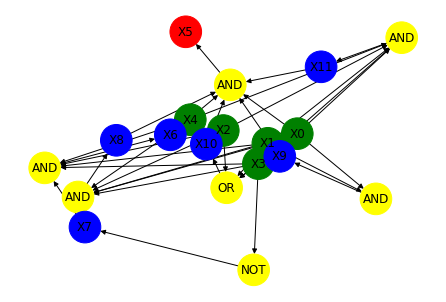

In [ ]:
def alinea_a():
  n_input = 5
  gamma = 0.3
  n_nodes, n_not,n_or,n_and = determine_each_node_value(n_input,gamma)
  circuit = generate_graph(n_input,n_not,n_or,n_and)

alinea_a()

## **Restrições**

Para determinar o vetor de inputs, temos que adicionar as restrições ao solver, para as diferentes possibilidades do valor do wire de output. Considerando y um wire de output, temos as seguintes condições:

* Para y=neg(x), temos que y+x=1
* Para y=or$(x_{1},..,x_{n})$, é necessário que $y\leq \sum_{i=1}^n x_{i} \quad \land \quad x_{i}\leq y$
* Para y=and$(x_{1},..,x_{n})$:$\sum_{i=1}^n x_{i} < y+n \quad \land \quad x_{i} \geq y$


[n_nodes = 10, n_not = 1, n_or = 1, n_and = 1]
n_nodes = 10
n_not = 1
n_or = 1
n_and = 1
X0 = 1
X1 = 1
X2 = 1
X3 = 1


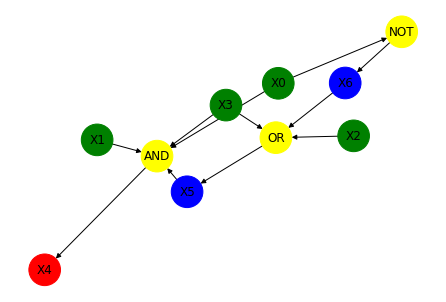

In [31]:
from ortools.linear_solver import pywraplp

def restricoes(circuit):
  s = pywraplp.Solver.CreateSolver("SCIP")
  input_ids = [i for i in circuit if circuit.in_degree(i) == 0]
  inputs = {i: s.BoolVar(i) for i in input_ids}
  for node in circuit:
    if "gate" in circuit.nodes[node]:
      gate_inputs = []
      for x,_ in circuit.in_edges(node):
        if x in input_ids:
          gate_inputs.append(inputs[x])
        else:
          gate_inputs.append(s.BoolVar(x))
        #gate_inputs = [s.BoolVar(x) for x, y in circuit.in_edges(node)]
        gate_output_id = [y for x, y in circuit.out_edges(node)][0]
        gate_output = s.BoolVar(gate_output_id)
        if circuit.nodes[node]["gate"] == "AND":
          s.Add(sum(gate_inputs) <= gate_output + len(gate_inputs)-1)
          for i in gate_inputs:
            s.Add(i >= gate_output)
        elif circuit.nodes[node]["gate"] == "OR":
          s.Add(gate_output <= sum(gate_inputs))
          for i in gate_inputs:
            s.Add(i <= gate_output)
        else:
          s.Add(gate_output + gate_inputs[0] == 1)
        if circuit.out_degree(gate_output_id) == 0:
          # print(gate_output_id)
          s.Add(gate_output == 1)

  if s.Solve() == pywraplp.Solver.OPTIMAL:
    for i in inputs.values():
      print(f'{i} = {round(i.solution_value())}')
  else:
    print("O problema não tem solução optimal")



n_input = 4
gamma = 0.1
n_nodes, n_not,n_or,n_and = determine_each_node_value(n_input,gamma)
circuit = generate_graph(n_input,n_not,n_or,n_and)
restricoes(circuit)